In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:90% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:12pt;}
div.text_cell_render.rendered_html{font-size:12pt;}
div.output {font-size:12pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:12pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe{font-size:12px;}
</style>
"""))

<b><font size="6" color="#009e84"> ch03. 한글 형태소 분석 / 시각화 / 유사도분석 / Quiz </font></b>

# ※ Quiz : 경주여행과 전주여행에 대해 최빈단어시각화와 유사도 분석

- (1) naver open API를 활용하여 네이버 지식인 '전주여행','경주여행'을 각각 500건씩 검색하여 백업(naver.csv)
    - replace(), re.sub()이용
    - 백업 파일 결과 : 검색어, no, title, link, description, total_text(title + ' ' + descricption)
- (2) 품사태깅 백업(naver_pos.csv)
    - query(검색어), no, token, pos(품사)
- (3) 명사만 추출 백업(naver_pos_nouns.csv)
    - query, token, pos
- (4) 빈도분석 백업(naver_pos_nouns_count.csv)
    - token, 경주빈도, 전주빈도, 빈도합
- (5) 빈도 시각화(워드클라우드, Text.plot)
    - 워드클라우드 이미지 저장
- (6) 단어간 유사도 분석(Word2Vec, 연관분석)

# 1. naver open API를 활용하여 검색어 500건 추출

- query, no, title, link, description, total_text(title + ' ' + descricption)

In [3]:
# .env파일 가져오기(방법1) - 주피터노트북 추천

from dotenv import load_dotenv
import os

load_dotenv()
# print(os.getenv('CLIENT_ID'))
# print(os.getenv('CLIENT_SECRET'))

True

In [5]:
# .env파일 가져오기(방법2) - vscode에서가 아니면 비추

from decouple import config
# print(config('CLIENT_ID'))
# print(config('CLIENT_SECRET'))

In [7]:
# 네이버 검색 API 예제 - 블로그 검색
import os
import sys
import urllib.request
client_id = os.getenv('CLIENT_ID')
client_secret = os.getenv('CLIENT_SECRET')
encText = urllib.parse.quote("경주 여행")
url = "https://openapi.naver.com/v1/search/blog?query=" + encText # JSON 결과
# url = "https://openapi.naver.com/v1/search/blog.xml?query=" + encText # XML 결과
request = urllib.request.Request(url)
request.add_header("X-Naver-Client-Id",client_id)
request.add_header("X-Naver-Client-Secret",client_secret)
response = urllib.request.urlopen(request)
rescode = response.getcode()
if(rescode==200):
    response_body = response.read()
    print(response_body.decode('utf-8')[:200]) # 딕셔너리처럼 보이지만 문자
else:
    print("Error Code:" + rescode)

{
	"lastBuildDate":"Tue, 02 Dec 2025 14:39:15 +0900",
	"total":1003198,
	"start":1,
	"display":10,
	"items":[
		{
			"title":"내 마음대로 기록하는 <b>경주여행<\/b> 2박3일",
			"link":"https:\/\/blog.naver.com\/hello


In [12]:
import requests
import pandas as pd
import json # response 텍스트를 json스타일의 딕셔너리로
import re   # 정규표현식
from html import unescape # description에 &lt;(<) &gt;(>) &nbsp;(스페이스)등의 특수문자를 <,>, 등의 문자로 변경

client_id = os.getenv('CLIENT_ID')
client_secret = os.getenv('CLIENT_SECRET')
query = '경주 여행'
start = 1
headers = {'X-Naver-Client-Id': client_id, 'X-Naver-Client-Secret' : client_secret}

# url = f'https://openapi.naver.com/v1/search/kin?query={query}&display=100&start={start}' 
# response = requests.get(url, headers=headers)
url = f'https://openapi.naver.com/v1/search/kin' 
params = {'query':query, 'display':100, 'start':start} # 파라미터가 길어질경우 사용
response = requests.get(url, params=params, headers=headers)

# print(response.text[:500])
# items = json.loads(response.text)['items']
items = response.json()['items']
len(items)

100

In [21]:
# title, link, description 추출(b태그 삭제, 특수문자 조정(&gt; → >), 정규표현식을 이용한 한글 추출)

# title, link, description 추출
item = items[97]
title = item.get('title').replace('<b>', '').replace('</b>', '')
link = item['link']
description = item.get('description').replace('<b>', '').replace('</b>', '')

# html 특수문자 처리
description = unescape(description)

# 정규표현식 : 알파벳, 숫자, 한글만 남기고 나머지는 제거
description = re.sub(r'[^a-zA-Z0-9가-힣]', ' ', description) # ^는 []안의 내용이 아니면 ' '스페이스로 바꿔라. []안의 내용에 부합하면 description으로 그대로 둬라
description = re.sub(r'\s+', ' ', description) # 스페이스가 한개이상 있으면 스페이스 하나만 두고 나머지는 그대로 둬라.

print(title, link, description)

경주 여행지 추천 https://kin.naver.com/qna/detail.naver?d1id=9&dirId=90111&docId=261370795&qb=6rK97KO8IOyXrO2WiQ==&enc=utf8  2 부산을 벗어난 경주 여행지 알려주세요 3 당일치기로 경주 여행코스 밑에 자세하게 권역별로 여행코스를 소개했습니다 경주여행이 처음이라면 대릉원 첨성대 참고로 쭈니아빠 블로그를 방문하시면 경주여행 


In [24]:
def get_search_element_return(query, start):
    headers = {'X-Naver-Client-Id': client_id, 'X-Naver-Client-Secret' : client_secret}
    url = f'https://openapi.naver.com/v1/search/kin' 
    params = {'query':query, 'display':100, 'start':start} # 파라미터가 길어질경우 사용
    response = requests.get(url, params=params, headers=headers)

    items = response.json()['items']
    result = [] # 검색한 정보를 append할 리스트
    
    for i, item in enumerate(items):
        title = item.get('title').replace('<b>','').replace('</b>','')
        link = item.get('link')
        description = item.get('description').replace('<b>','').replace('</b>','')
        
        #특수문자 처리
        description = unescape(description)
        
        #영문자, 숫자, 한글을 제외한 문자 제거
        description = re.sub(r'[^a-zA-Z0-9가-힣]', ' ', description)
        description = re.sub('\s+', ' ', description)
        
        # 리스트에 추가
        result.append({'query':query, 
                       'no': (start-1)*100 + i+1, # 1페이지는 1,2,3, / 2페이지는 101,102,103 이런식으로 나와야해서
                       'tilte': title,
                       'link':link,
                       'description': description,
                       'total_text':title + ' ' + description})
    return result

In [26]:
get_search_element_return('경주여행',3)

[{'query': '경주여행',
  'no': 201,
  'tilte': '6~7월 경주 여행에서 꼭 가봐야 할 명소는?',
  'link': 'https://kin.naver.com/qna/detail.naver?d1id=9&dirId=90105&docId=486500596&qb=6rK97KO87Jes7ZaJ&enc=utf8',
  'description': ' 질문하신 경주 여행 명소 관련 답변 드리도록 하겠습니다 6 7월에 방문하기 좋은 경주 명소로는 동궁과 월지 석굴암 경주 동궁원 월정교 오류고아라해변 등이 있습니다 여행하시는데 참고하시기 바랍니다 도움이 되셨다면 채택 ',
  'total_text': '6~7월 경주 여행에서 꼭 가봐야 할 명소는?  질문하신 경주 여행 명소 관련 답변 드리도록 하겠습니다 6 7월에 방문하기 좋은 경주 명소로는 동궁과 월지 석굴암 경주 동궁원 월정교 오류고아라해변 등이 있습니다 여행하시는데 참고하시기 바랍니다 도움이 되셨다면 채택 '},
 {'query': '경주여행',
  'no': 202,
  'tilte': '경주 여행 시 황리단길에서 꼭 방문해야 할 카페와 맛집... ',
  'link': 'https://kin.naver.com/qna/detail.naver?d1id=9&dirId=90111&docId=489677065&qb=6rK97KO87Jes7ZaJ&enc=utf8',
  'description': '경주 여행을 계획 중이며 황리단길에서 꼭 들러야 할 카페와 맛집을 알고 싶습니다 특히 현지인들에게 인기 있는 곳이나 특별한 메뉴가 있는 곳을 추천해주실 수 있나요 황리단길을 구경하면서 여러가지 볼거리먹 거리 카페가 있어니 ',
  'total_text': '경주 여행 시 황리단길에서 꼭 방문해야 할 카페와 맛집...  경주 여행을 계획 중이며 황리단길에서 꼭 들러야 할 카페와 맛집을 알고 싶습니다 특히 현지인들에게 인기 있는 곳이나 특별한 메뉴가 있는 곳을 추천해주실 수 있나요 황리단길을 구경하면서 여러가

In [30]:
import time

result_total = [] # 모든 검색 결과
queries = ['전주 여행', '경주 여행']
max_start = 5

for query in queries:
    for start in range(1, max_start+1): # 유지보수를 고려한 코딩. 6이라고 적으면 하드코딩
        print(start, query, '읽는중')
        result_total.extend(get_search_element_return(query, start)) # 여기는 append가 아니라 차곡차곡 쌓이게 extend를 써야함
        time.sleep(0.5)
df = pd.DataFrame(result_total)
df.to_csv('data/naver.csv', index=False, sep=',')

1 전주 여행 읽는중
2 전주 여행 읽는중
3 전주 여행 읽는중
4 전주 여행 읽는중
5 전주 여행 읽는중
1 경주 여행 읽는중
2 경주 여행 읽는중
3 경주 여행 읽는중
4 경주 여행 읽는중
5 경주 여행 읽는중


# 2. 품사태깅 백업(naver_pos.csv)

- query(검색어), no, token, pos(품사)

In [31]:
import pandas as pd

df = pd.read_csv('data/naver.csv')
df.tail(1)

,query,no,tilte,link,description,total_text
999,경주 여행,500,경주여행!!,https://kin.naver.com/qna/detail.naver?d1id=9&...,경주 여행을 가려고 하는데 혹시 경주에 폴라로이드 카메라 대여 할 수 있는곳이나 싸...,경주여행!! 경주 여행을 가려고 하는데 혹시 경주에 폴라로이드 카메라 대여 할 수 ...


In [34]:
df_list = df[['query', 'no', 'total_text']].values.tolist() # 데이터프레임을 for문 돌리면 되게 없어보여서 바꾸는것
df_list[::250]

[['전주 여행',
  1,
  '25년10월5,6,7일 전주여행  전주여행 가볼만한 곳 추천부탁드립니다 25년 10월 초 전주여행 아이들과 함께 가기 좋은 시점이에요 추석에는 문 연 곳이 적을 수 있지만 전주 한옥마을이나 전주비빔밥 맛집은 추천해용 차는 밀릴 가능성이 높으니 미리 출발하는 '],
 ['전주 여행',
  251,
  '[추천해주세요] 전주 당일치기 여행  추천해주세요 전주 당일치기 여행 전주여행 전주맛집 국내여행 전주달봉이 달봉티비 전주여행코스 전주가볼만한곳 여수여행 여수가볼만한곳 제주도여행 제주도가볼만한곳 여행 전문 인플루언서 전주달봉이입니다 '],
 ['경주 여행',
  1,
  'APEC 기간 경주여행 APEC 기간 경주여행 어떻게 생각하시나요 APEC 기간에 경주여행은 좋은 방법이에요 역사와 문화가 가득한 도시에서 특별한 경험을 할 수 있을 거에요 즐거운 여행 되세요 '],
 ['경주 여행',
  251,
  '경주 여행 코스 어디가★ 가족들이랑 경주여행을 가려고 하는데 경주 여행 코스를 어떻게 해야할지 모르겟네요 경주 여행 코스 어디가 좋을까요 사실 중학교때 가보고 안가봤어요 경주 여행코스 가장 핫플레이스만 가보고 싶어요 혹시 경주 여행코스 다들 ']]

In [46]:
%%time

from mecab import MeCab

mecab = MeCab()
stopwords = {'전주', '경주', '여행'}
postagged_list = [] # query, no, token, pos 딕셔너리 list

for i, row in enumerate(df_list):
    query = row[0]
    no    = row[1]
    text  = row[2]
    tagged_text = mecab.pos(text)
    
#     결과가 궁금해서 프린트해본것
#     if i%250==0:
#         print(f'{query}의 {no}번째 품사태깅 결과 : {len(tagged_text)}개')
#         print(tagged_text[5:15]) 

    for token, pos in tagged_text:
#         if token not in stopwords and pos in select_pos: # 불용어 제외한 명사
#         if token not in stopwords and len(token)>1: # 불용어 제외 한글자 이상만 append
        if token not in stopwords: # 불용어 제외
            postagged_list.append({'query':query,
                                   'no':no,
                                   'token':token,
                                   'pos':pos})
df_postagged = pd.DataFrame(postagged_list)
df_postagged.to_csv('data/naver_pos.csv', index=False, encoding='cp949')

CPU times: total: 703 ms
Wall time: 709 ms


In [47]:
df_postagged.shape

(54146, 4)

# 3. 명사만 추출 백업(naver_pos_nouns.csv)

- query, token, pos

In [49]:
import pandas as pd

df_postagged = pd.read_csv('data/naver_pos.csv', encoding='cp949')
df_postagged.head(1)

,query,no,token,pos
0,전주 여행,1,25,SN


In [51]:
select_pos = ['NNP', 'NNG'] # mecab의 명사 pos tag
df_nouns = df_postagged[df_postagged['pos'].isin(select_pos)]
df_nouns.to_csv('data/naver_pos_nouns.csv', index=False, encoding='cp949')

# 4. 빈도분석 백업(naver_pos_nouns_count.csv)

- token, 경주빈도, 전주빈도, 빈도합

In [52]:
df_nouns = pd.read_csv('data/naver_pos_nouns.csv', encoding='cp949')
df_nouns.head()

,query,no,token,pos
0,전주 여행,1,곳,NNG
1,전주 여행,1,추천,NNG
2,전주 여행,1,부탁,NNG
3,전주 여행,1,아이,NNG
4,전주 여행,1,시점,NNG


In [56]:
df_nouns.groupby(['query', 'token'], as_index=False)['pos'].count() # as_index=False 하면 데이터프레임으로 보임

,query,token,pos
0,경주 여행,가격,5
1,경주 여행,가능,30
2,경주 여행,가보세요,10
3,경주 여행,가본적,5
4,경주 여행,가시,5
...,...,...,...
997,전주 여행,효율,5
998,전주 여행,후,5
999,전주 여행,휴가,5
1000,전주 여행,휴무,5


In [59]:
df_token_grp = df_nouns.groupby('query')['token'].value_counts()
df_token_grp = df_token_grp.reset_index(name='token_count')

In [60]:
df_token_grp.head()

,query,token,token_count
0,경주 여행,코스,447
1,경주 여행,추천,424
2,경주 여행,계획,151
3,경주 여행,곳,134
4,경주 여행,맛집,133


In [67]:
df_gj = df_token_grp.loc[df_token_grp['query']=='경주 여행', ['token', 'token_count']]
df_jj = df_token_grp.loc[df_token_grp['query']=='전주 여행', ['token', 'token_count']]
df_gf.shape, df_jj.shape

((536, 2), (466, 2))

In [68]:
df_gj.head()

,token,token_count
0,코스,447
1,추천,424
2,계획,151
3,곳,134
4,맛집,133


In [66]:
df_jj.head()

,token,token_count
536,코스,459
537,곳,433
538,봉,330
539,맛집,322
540,여수,315


In [75]:
# df_gj(경주 명사 출현횟수), df_jj(전주 명사 출현횟수) 병합
import numpy as np

df_mrg = pd.merge(df_gj, df_jj, on='token', how='outer') # 공통된 내용만 나옴 / how='outer'을 하면 겹치지 않은것도 다 나오게하는것
df_mrg.columns = ['token', '경주빈도', '전주빈도']
df_mrg.fillna(0, inplace=True) # NaN에 0 넣는것
df_mrg['경주빈도'] = df_mrg['경주빈도'].astype('int')
df_mrg['전주빈도'] = df_mrg['전주빈도'].astype(np.int32)
df_mrg.head()

,token,경주빈도,전주빈도
0,코스,447,459
1,추천,424,289
2,계획,151,64
3,곳,134,433
4,맛집,133,322


In [79]:
df_mrg['빈도합'] = df_mrg['경주빈도'] + df_mrg['전주빈도']
df_mrg['경주비율'] = df_mrg['경주빈도'] / df_mrg['빈도합']
df_mrg['전주비율'] = df_mrg['전주빈도'] / df_mrg['빈도합']
df_mrg['경주비율'] = df_mrg['경주비율'].apply(lambda x : '{:.2%}'.format(x))
df_mrg['전주비율'] = df_mrg['전주비율'].apply(lambda x : '{:.2%}'.format(x))
df_mrg.head()

,token,경주빈도,전주빈도,빈도합,경주비율,전주비율
0,코스,447,459,906,49.34%,50.66%
1,추천,424,289,713,59.47%,40.53%
2,계획,151,64,215,70.23%,29.77%
3,곳,134,433,567,23.63%,76.37%
4,맛집,133,322,455,29.23%,70.77%


In [80]:
df.to_csv('data/naver_pos_nouns_count.csv', index=False, encoding='cp949')

# 5. 빈도 시각화(워드클라우드, Text.plot)

- 전주여행 / 경주여행 워드클라우드 이미지 저장

In [81]:
df_nouns = pd.read_csv('data/naver_pos_nouns.csv', encoding='cp949')
df_nouns.loc[::5000]

,query,no,token,pos
0,전주 여행,1,곳,NNG
5000,전주 여행,272,곳,NNG
10000,경주 여행,53,때,NNG
15000,경주 여행,375,제외,NNG


In [87]:
df_gj_noun = df_nouns.loc[df_nouns['query']=='경주 여행', 'token'].to_list()
df_jj_noun = df_nouns.loc[df_nouns['query']=='전주 여행', 'token'].to_list()
gj_text = ' '.join(df_gj_noun)
jj_text = ' '.join(df_jj_noun)

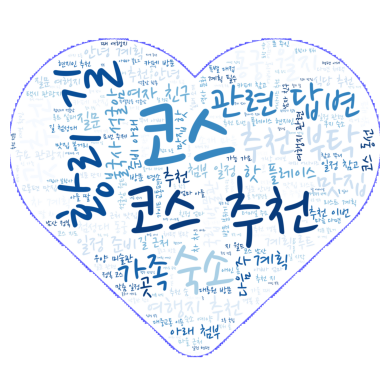

In [94]:
import numpy as np
from PIL import Image
from wordcloud import WordCloud
import matplotlib.pyplot as plt

img = Image.open('data/heart.jpg')
mask = np.array(img)
불용어 = set()
wordcloud = WordCloud(font_path='data/NanumPenScript-Regular.ttf',
                      background_color='white',
                      colormap='Blues',
                      collocations=True, # 특정단어가 자주 같이 나오면 같이 뿌려라 ex) 황리, 길
                      max_words=200,
                      scale=2, # 이미지 크기의 비율(파일 저장시)
                      mask=mask,
                      contour_color='blue',
                      contour_width=1).generate(gj_text)


plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [95]:
# 생성된 워드 클라우드 저장

wordcloud.to_file('data/naver_경주.jpg')

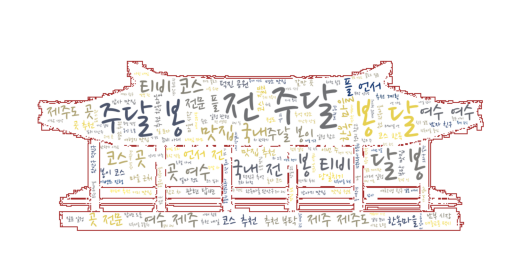

In [99]:
import numpy as np
from PIL import Image
from wordcloud import WordCloud
import matplotlib.pyplot as plt

img = Image.open('data/korea-house-black-fill.png')
mask = np.array(img)
불용어 = set()
wordcloud = WordCloud(font_path='data/NanumPenScript-Regular.ttf',
                      background_color='white',
                      colormap='cividis',
                      collocations=True, # 특정단어가 자주 같이 나오면 같이 뿌려라 ex) 황리, 길
                      max_words=200,
                      scale=2, # 이미지 크기의 비율(파일 저장시)
                      mask=mask,
                      contour_color='brown',
                      contour_width=1).generate(jj_text)


plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## 빈도수 시각화(nltk.Text)

In [100]:
df_gj_noun_list = df_nouns.loc[df_nouns['query']=='경주 여행', 'token'].to_list()
df_jj_noun_list = df_nouns.loc[df_nouns['query']=='전주 여행', 'token'].to_list()

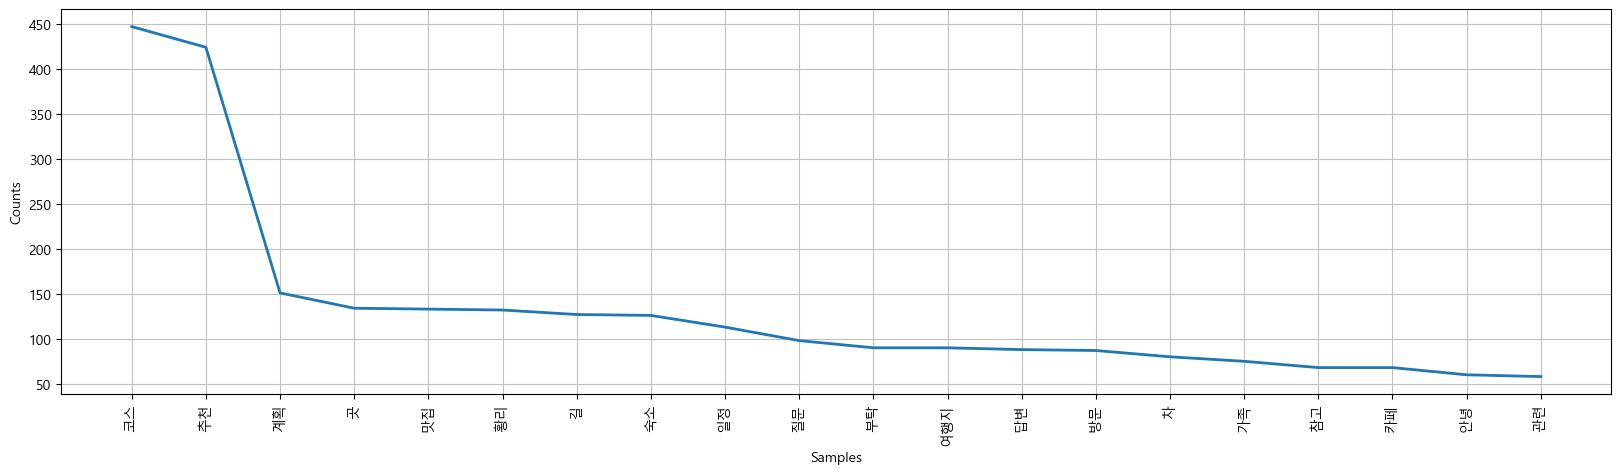

In [101]:
import nltk
data_text = nltk.Text(df_gj_noun_list)
plt.figure(figsize=(20,5))
plt.rc('font', family='Malgun Gothic')
data_text.plot(20)
plt.show()

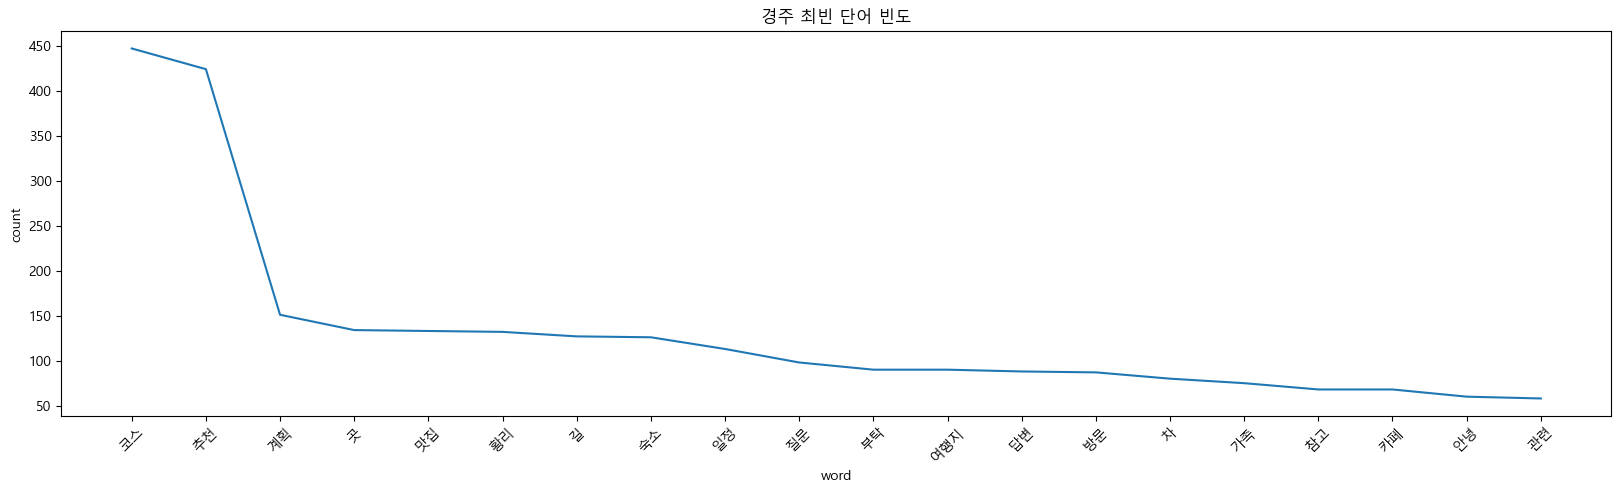

In [107]:
# 위에서는 이런 조정을 할 수 없어서 이런저런 조정을 하고싶다면 아래처럼 해야함

word, counts = zip(*data_text.vocab().most_common(20))
# print(word)
# print(counts)

plt.figure(figsize=(20,5))
plt.plot(word, counts)
plt.xticks(rotation=45)
plt.xlabel('word')
plt.ylabel('count')
plt.title('경주 최빈 단어 빈도')
plt.show()

# 6. 단어간 유사도 분석(Word2Vec, 연관분석)

In [108]:
df = pd.read_csv('data/naver.csv')
df.sample()

,query,no,tilte,link,description,total_text
848,경주 여행,349,6월 경주여행,https://kin.naver.com/qna/detail.naver?d1id=9&...,제가 6월달에 엄마아빠랑 언니랑 경주여행을 가는데요 갈곳 추천해주세요 너무 유명한 ...,6월 경주여행 제가 6월달에 엄마아빠랑 언니랑 경주여행을 가는데요 갈곳 추천해주세요...


In [111]:
total_text_list = df['total_text'].to_list()
total_text_list[:2]

['25년10월5,6,7일 전주여행  전주여행 가볼만한 곳 추천부탁드립니다 25년 10월 초 전주여행 아이들과 함께 가기 좋은 시점이에요 추석에는 문 연 곳이 적을 수 있지만 전주 한옥마을이나 전주비빔밥 맛집은 추천해용 차는 밀릴 가능성이 높으니 미리 출발하는 ',
 'KTX로 떠나는 전주 여행, 주요 관광지 도보 이동...   전주 여행 계획 중이시군요 전주역에서 한옥마을까지는 사실 도보로는 좀 멀어요 약 3km 정도 되고 40분 정도 걸립니다 그래서 대부분 택시나 버스를 이용하시는데 택시는 10분 정도면 도착하고 요금도 7 8천원 정도로 부담 없어요 ']

In [115]:
from mecab import MeCab

select_pos = ['NNP', 'NNG']
불용어 = {'여행'}
mecab = MeCab()
total_noun_list = []

for total_text in total_text_list:
    noun_list = [token for token, tag in mecab.pos(total_text) if tag in select_pos and token not in 불용어 and len(token)>1]
    total_noun_list.append(noun_list)
print(total_noun_list[:2])

[['전주', '전주', '추천', '부탁', '전주', '아이', '시점', '추석', '전주', '한옥마을', '전주비빔밥', '맛집', '추천', '해용', '가능', '출발'], ['전주', '주요', '관광지', '도보', '이동', '전주', '계획', '주역', '한옥마을', '도보', '정도', '정도', '대부분', '택시', '버스', '이용', '택시', '정도', '도착', '요금', '정도', '부담']]


In [116]:
from gensim.models import Word2Vec

model = Word2Vec(total_noun_list, window=10, min_count=2, workers=-1, sg=1) # sg는 소량 데이터

In [117]:
model.wv.most_similar('전주')

[('부부', 0.3595535457134247),
 ('야경', 0.2897421419620514),
 ('리스트', 0.275379478931427),
 ('덕진구', 0.2731468081474304),
 ('코로나', 0.2580290138721466),
 ('전라도', 0.2295033037662506),
 ('미술관', 0.22023281455039978),
 ('답변', 0.21883943676948547),
 ('한옥마을', 0.21617142856121063),
 ('시절', 0.2135322391986847)]

In [118]:
model.wv.most_similar('경주')

[('편리', 0.3641005754470825),
 ('영화제', 0.21867415308952332),
 ('할증', 0.21632219851016998),
 ('연령', 0.2159893959760666),
 ('완산구', 0.21469099819660187),
 ('황동', 0.2134207934141159),
 ('독일', 0.20914912223815918),
 ('포석정', 0.20906010270118713),
 ('패딩', 0.2070489227771759),
 ('개인', 0.20607852935791016)]

## 연관분석

In [120]:
print(total_noun_list[:2])

[['전주', '전주', '추천', '부탁', '전주', '아이', '시점', '추석', '전주', '한옥마을', '전주비빔밥', '맛집', '추천', '해용', '가능', '출발'], ['전주', '주요', '관광지', '도보', '이동', '전주', '계획', '주역', '한옥마을', '도보', '정도', '정도', '대부분', '택시', '버스', '이용', '택시', '정도', '도착', '요금', '정도', '부담']]


In [124]:
%%time

from apyori import apriori

rules = apriori(total_noun_list, min_support=0.15, min_confidence=0.3, min_lift=1.01)
rules = list(rules)
len(rules)

CPU times: total: 31.2 ms
Wall time: 32.4 ms


125

In [126]:
import pandas as pd

rules_df = pd.DataFrame(None, columns=['lhs', 'rhs', '지지도', '신뢰도', '향상도'])

idx = 0
for row in rules:
    support = row[1]
    ordered_st = row[2]
    for item in ordered_st:
        lhs = item[0]
        lhs = ','.join([x for x in lhs])
        rhs = item[1]
        rhs = ','.join([x for x in rhs])
        confidence = item[2]
        lift = item[3]
        rules_df.loc[idx] = [lhs, rhs, support, round(confidence, 2), round(lift, 2)]
        idx += 1
        
rules_df = rules_df.sort_values(by=['신뢰도', '향상도'], ascending=False)
rules_df.head(10)

,lhs,rhs,지지도,신뢰도,향상도
102,"여수,국내",티비,0.150,1.0,6.06
132,"주달,국내",티비,0.155,1.0,6.06
138,"코스,국내",티비,0.155,1.0,6.06
162,"여수,맛집",티비,0.155,1.0,6.06
228,"주달,여수",티비,0.155,1.0,6.06
234,"여수,코스",티비,0.155,1.0,6.06
307,"여수,국내","티비,맛집",0.150,1.0,6.06
312,"여수,맛집,국내",티비,0.150,1.0,6.06
377,"주달,국내","티비,맛집",0.155,1.0,6.06
382,"주달,맛집,국내",티비,0.155,1.0,6.06
